In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import rarfile

from tqdm import tqdm
import json

import pandas as pd
import numpy as np
import re
import jieba
from bertopic import BERTopic

/tmp/ipykernel_1816/2351800022.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 读取数据

In [2]:
WEIBO_POST_PATH = "./data/2024_0131/Weibo/post"
WEIBO_ACCOUNT_PATH = "./data/2024_0131/Weibo/account"
post_all_data = []
for filename in tqdm(os.listdir(WEIBO_POST_PATH)):
    if filename.endswith('.json'):
        file_path = os.path.join(WEIBO_POST_PATH, filename)
        with open(file_path, 'r',encoding='utf-8') as file:
            data_group = json.load(file)
            post_all_data.extend(data_group)
print(len(post_all_data))
# 查找其中空的数据，并删除
post_all_data = [data for data in post_all_data if "content" in data]
print(len(post_all_data))

100%|██████████| 2472/2472 [00:01<00:00, 1845.55it/s]


234391
200739


### 时间分布

In [3]:
# 时间分布,字段为publish_time，比如20230415230803
from datetime import datetime
time_count = {}
for data in post_all_data:
    time = data['publish_time']
    time = datetime.strptime(time, '%Y%m%d%H%M%S')
    time = time.strftime('%Y-%m-%d')
    if time in time_count:
        time_count[time] += 1
    else:
        time_count[time] = 1

In [4]:
time_count.keys()

dict_keys(['2023-06-26', '2023-06-07', '2023-06-28', '2023-06-27', '2023-06-29', '2023-06-13', '2023-06-12', '2023-06-06', '2023-06-08', '2023-08-23', '2023-08-24', '2023-08-17', '2023-08-16', '2023-08-20', '2023-08-19', '2023-08-18', '2023-08-21', '2023-08-22', '2023-07-31', '2023-07-30', '2023-07-28', '2023-07-27', '2023-07-29', '2023-11-09', '2023-11-08', '2023-09-07', '2023-11-10', '2023-11-01', '2023-11-02', '2023-10-31', '2023-11-03', '2023-11-12', '2023-11-14', '2023-11-13', '2023-11-06', '2023-11-07', '2023-11-05', '2023-11-04', '2023-11-17', '2023-05-26', '2023-12-15', '2023-12-03', '2023-12-02', '2023-09-25', '2023-10-20', '2023-12-05', '2023-12-04', '2023-12-06', '2023-12-08', '2023-12-07', '2023-12-01', '2023-12-23', '2023-12-21', '2023-10-29', '2023-07-04', '2023-07-03', '2023-07-01', '2023-07-05', '2023-07-07', '2023-07-06', '2023-07-09', '2023-07-11', '2023-07-10', '2023-07-12', '2023-07-17', '2023-07-16', '2023-07-15', '2023-07-18', '2023-07-19', '2023-07-21', '2023-07-

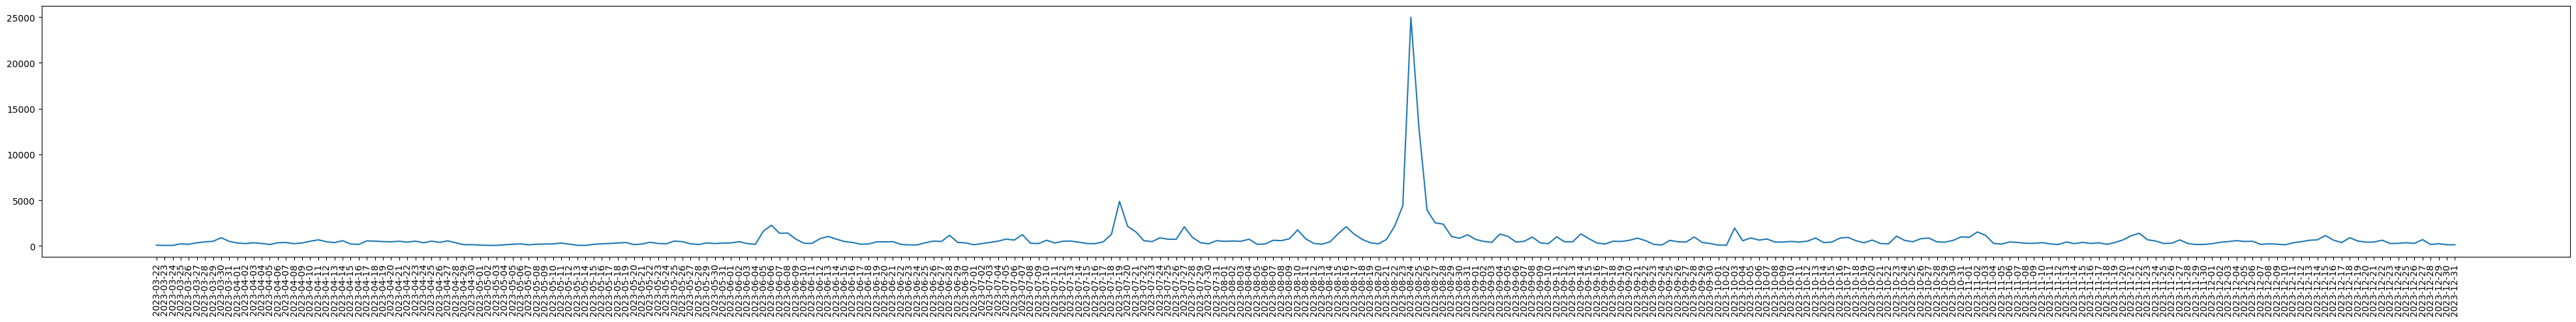

In [9]:
# 时间分布可视化
# 首先去除2023年之前的数据
time_count_data = {k: v for k, v in time_count.items() if k > '2023-01-01' and v > 50}
time_count_data = sorted(time_count_data .items(), key=lambda x: x[0])
plt.figure(figsize=(50, 5))
plt.plot([x[0] for x in time_count_data], [x[1] for x in time_count_data])
# 90
plt.xticks(rotation=90)
plt.show()

## 预处理

In [19]:
# 定义函数去除标点符号和网址
def remove_punctuation_and_urls(text):
    # 去除标点符号
    text = re.sub(r'[^\w\s]', '', text)
    # 去除网址
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    return text
stopwords = ["的", "是", "在", "了", "和", "也", "等", "对", 
             "与", "中", "于", "以", "对于", "则", "能", "可",
               "会", "就", "这","全文","展开","微博","链接","转发","RT"]
def cut_text(text):
    return " ".join([word for word in jieba.cut(text) if word not in stopwords])

In [25]:
for data in tqdm(post_all_data):
    text = remove_punctuation_and_urls(data['content'])
    text = cut_text(text)
    data['content_process'] = text

100%|██████████| 200739/200739 [01:45<00:00, 1907.29it/s]


# 聚类

In [27]:
from bertopic import BERTopic
docs = [data['content_process'] for data in post_all_data]
docs[0]

'快转   RTCCTV 国际 时讯   日本 核污染 水排 海 倒计时 日本 核污染 水排 海 隧道 重型 设备 拆除 据 日本 福岛 当地 媒体报道 东京 电力公司 当地 时间 26 日 早上 7 点 05 分 北京 时间 今早 6 点 05 分 左右 开始 福岛 第一 核电站 核污染 水排 海 隧道 中重型 设备 拆除 潜水 作业 当地 时间 上午 9 点半 北京 时间 今早 8 点半 潜水 拆除 作业 完成 之后 东电    '

In [29]:
topic_model = BERTopic(language="chinese (simplified)")
topics, _ = topic_model.fit_transform(docs)

In [ ]:
topic_model.get_topic_info()

In [ ]:
# 查找有没有"大选"
for i in range(len(post_all_data)):
    if "大选" in post_all_data[i]['content_process']:
        print(post_all_data[i]['content_process'])